# Matching Algorithm

*Algorithm which takes all the extracted data of mentors and applicants and matches them based on a scoring system of similarities*

**Note:** Data cleaning on Excel was done with 'find' and 'replace' to make all country names one word (by adding '_' in spaces)

**STEP 1:** Make list of countries which fall into Minerva outreach regions

**STEP 2:** Create lists of lists of mentor interests, mentory country, and mentor status where the sublists are created from splitting the strings

**STEP 3:** Define matching function which gives scores to every mentor and applicant match based on prioritisation of similarities

**STEP 4:** Create heatmap function to create visualisations of matching scores across mentors and admit pairs.

**STEP 5:** Create lists of lists of admit interests, admit country, and admit status where the sublists are created from splitting the strings

**STEP 6:** Match admits to mentors using the matching function and store resulting lists in dataframe. Create heatmap visualisation to show matching scores.

**STEP 7:**  Keep only top matches per admit and drop duplicates in a way which most evens out distribution of applicants 

**STEP 8:** Convert DataFrame of unique matches to Excel Sheet

**STEP 9:** Create bar charts of the scores of unique matches for each mentor to be used to latest survey/test the success of the best/worst matches

### Import libraries and data used

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.plotly as py
% matplotlib inline

mentors = pd.read_excel("pairing_data.xlsx", sheetname = "mentors")
admits = pd.read_excel("pairing_data.xlsx", sheetname = "admits")

In [24]:
mentors.head()

,MENTOR,COUNTRY,REGION,2-STATUS,INTERESTS
0,A,Brazil,Latin America,Transfer,Computer/Technology Journalism_&_Media Service...
1,B,South_Africa,Africa,Transfer,Leadership Computer/Technology Design_&_Crafti...
2,C,US,North America,High school,Foreign_Language Education STEM_Research Compu...
3,D,Norway,Europe,Gap year,Public_Speaking Computer/Technology STEM_Resea...
4,E,Russia,Europe,Gap year,Computer/Technology Music STEM_Research Journa...


In [25]:
admits.head()

,APPLICANT,COUNTRY,2-STATUS,INTERESTS
0,1,India,Transfer,Athletics Performing_Art
1,2,Pakistan,High school,Education Public_Speaking Computer/Technology
2,3,US,High school,Athletics STEM_Research
3,4,Vietnam,High school,Education Public_Speaking Journalism_&_Media
4,5,Kenya,Gap year,Business


### STEP 1:

Make list of countries which fall into Minerva outreach regions

In [26]:
# Regions: This is based on looking up countries from each region, should check with Minerva about their own lists. 

countries_per_region = {
    "Latin America": [
        "Brazil", "Venezuela", "Argentina", "Peru", "Colombia", "Columbia" "Chile", "Ecuador",
        "Bolivia", "Uruguay", "Paraguay", "Guyana", "Jamaica", "Mexico", "Honduras", "St_Lucia",
        "Suriname", "Trinidad_and_Tobago", "Costa_Rica", "Barbados", "Belize", "St_Kitts_and_Nevis",
        "Gautemala", "El_Salvador", "Dominican_Republic", "Bahamas", "Panama", "Haiti",
        "Nicaragua", "Cuba", "Antigua_and_Deps", "Grenada", "Belize", "Dominica", "Saint_Vincent_and_the_Grenadines"
    ],

    "North America": [
        "US", "Canada", "Peurto_Rico"
    ],

    "Africa": [
        "Morocco", "South_Africa", "Algeria", "Nigeria", "Ethiopia", "Kenya", 
        "Tunisia", "DRC", "Cape_Verde", "Tanzania", "Madagascar", "Ghana",
        "Libya", "Mali", "Cameroon", "Uganda", "Gambia", "Sudan", "Senegal", "Ivory Coast", 
        "Zimbabwe", "Somalia", "Namibia", "Mozambique", "Angola", "Rwanda",
        "Burkina_Faso", "Zambia", "Botswana", "Guinea", "Chad", "South_Sudan", 
        "Malawi", "Liberia", "Niger", "Benin", "Togo", "Djibouti", 
         "Central_African_Republic", "Congo", "Swaziland", "Lesotho",
        "Syria", "Turkey", "Iran", "Saudi_Arabia", "United_Arab_Emirates",
        "Egypt", "Iraq", "Qatar", "Palestine", "West_Bank", "Palestinian_Territory", 
        "Lebanon", "Yemen", "Jordan", "Bahrain", "Oman", "Sao_Tome_and_Principe",
        "Kuwait", "Comoros", "Equatorial_Guinea", "Eritrea", "Mauritius", "Seychelles",
        "Gabon", "Mauritania", "Sierra_Leone", "Guinea-Bissau", "Afghanistan", "Pakistan"
    ],

    "Europe": [
        "Israel", "Germany", "Italy", "France", "UK", "Netherlands", "Holland", "Switzerland", "Poland", "Ukraine",
         "Greece", "Sweden", "Austria", "Malta", "Norway", "Czech_Republic", "Denmark", "Croatia", "Belgium",
         "Iceland", "Romania", "Finland", "Hungary", "Bulgaria", "Luxembourg", 
         "Albania", "Serbia", "Montenegro", "Vatican_City", "Lithuania", "Slovenia", "Estonia", "Ireland",
         "Kosovo", "Slovakia", "Bosnia_Herzegovina", "Moldova", "Latvia", "Belarus", "Macedonia",
         "Russia", "Russian_Federation", "Armenia", "Uzbekistan", "Tajikistan",
         "Georgia", "Spain", "Portugal", "Azerbaijan", "Croatia", "Cyprus",
        "Kazakhstan", "Kyrgyzstan", "Andorra", "Turkmenistan", "Belgium", 
        "Greenland", "Liechtenstein", "Monaco", "Saint_Martin", "San_Marino"
    ],

    "Asia": [
        "India", "China", "Japan", "Vietnam", "North_Korea", "Thailand",
        "Singapore", "South_Korea", "Philippines", "Hong_Kong", "Indonesia", "Maldives", "Myanmar", 
        "Burma", "Malaysia", "Sri_Lanka", "Bangladesh", "Taiwan", "Cambodia", "Nepal", "Laos", "Mongolia", 
        "Bhutan", "East_Timor", "Australia", "New_Zealand", "Fiji", "Marshall_Islands",
        "Papua_New_Guinea", "Kiribati", "Micronesia", "Samoa", "Solomon_Islands",
        "Nauru", "Palau", "Tonga", "Tuvalu", "Vanuatu", "Brunei"
    ],
}

### STEP 2:

Create lists of lists of mentor interests, mentory country, and mentor status where the sublists are created from splitting the strings

In [27]:
mentor_interests = []
x = 0
while x < len(mentors):
    split = mentors["INTERESTS"][x].split()
    mentor_interests.append(split)
    x += 1

In [28]:
mentor_country = []
x = 0
while x < len(mentors):
    split = mentors["COUNTRY"][x].split()
    mentor_country.append(split)
    x += 1

In [29]:
mentor_status = mentors["2-STATUS"].tolist()

In [30]:
mentor_region = []
regions = mentors["REGION"].tolist()

for region in regions:
    countries = countries_per_region[region]
    mentor_region.append(countries)

### STEP 3:

Define matching function which gives scores to every mentor and applicant match based on prioritisation of similarities

In [31]:
def match(iden, country, status, interests):
    x = 0
    while x < len(mentors):
        y = 0
        while y < len(iden):
            score = 0
            mentor =  mentors.iloc[x]
            admit = iden[y]
            if country[y][0] in mentor_country[x]:
                score += 50
            # the following only adds 20 points, if admit_country does not equal mentor_country
            if country[y][0] not in mentor_country[x] and country[y][0] in mentor_region[x]:
                score += 20
            if mentor_status[x] == status[y]:
                score += 15
            for interest in interests[y]:
                if interest in mentor_interests[x]:
                    score += 15
            applicant.append(admit)
            student.append([mentor[0]])
            scores.append(score)
            y += 1
        x += 1 

### STEP 4: 

Create heatmap function to create visualisations of matching scores across mentors and admit pairs.

In [71]:
mentor_labels = []

def heatmap_data():
    y = 0
    while y < len(mentors):
        scoring = []
        x = 0
        while x < len(matches):
            if mentors['MENTOR'].iloc[y] == matches['MENTOR'].iloc[x]:
                applicant_labels.append(matches['APPLICANT'].iloc[x])
                scoring.append(int(matches['SCORE'].iloc[x])) 
            x += 1
        mentor_labels.append(mentors['MENTOR'].iloc[y])
        points.append(scoring)
        y += 1

## Matching all admits at once 

### STEP 5:

Create lists of lists of admit interests, admit country, and admit status where the sublists are created from splitting the strings

In [33]:
admit_id =  admits["APPLICANT"].tolist()

In [34]:
admit_country = []
x = 0
while x < len(admits):
    split = unicode(admits["COUNTRY"][x]).split() # unicode necessary so that the object is the same of that of mentor_country
    admit_country.append(split)
    x += 1

In [35]:
admit_status = admits["2-STATUS"].tolist()

In [36]:
admit_interests = []
x = 0
while x < len(admits):
    split = str(admits["INTERESTS"][x]).split()
    split = set(split)
    split = list(split)
    admit_interests.append(split)
    x += 1

### STEP 6:

Match admits to mentors using the matching function and store resulting lists in dataframe. Create heatmap visualisation to show matching scores.

In [37]:
# global lists used in matching function
applicant = []
student = []
scores = []

match(admit_id, admit_country, admit_status, admit_interests)

In [43]:
matches = pd.DataFrame(np.column_stack([student, applicant, scores]), 
                               columns=['MENTOR', 'APPLICANT', 'SCORE'])

In [52]:
applicant_labels = [] # use for x = in trace, if the labels are not numbered
points = []
heatmap_data()

trace = go.Heatmap(z= points,
                   y= mentor_labels)
data=[trace]
layout = go.Layout(
    title='Mentor-Admit Matching Score for 460 Admits and 20 Mentors',
    xaxis=dict(
        title='Admits',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f')),
    yaxis = dict(
    title = 'Mentors',
    titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f')))

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='labelled-heatmap')

High five! You successfuly sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~kalia/0 or inside your plot.ly account where it is named 'labelled-heatmap'


### STEP 7:

Keep only top matches per admit and drop duplicates in a way which most evens out distribution of applicants

In [54]:
# dataframe which only keeps the top matches per admit
by_applicant = matches.groupby("APPLICANT")["SCORE"].transform(max) == matches["SCORE"]
top_matches = matches[by_applicant]

# dataframe which sorts based on the mentor with the least to most matches
top_matches['count'] = top_matches.groupby(['MENTOR'])['APPLICANT'].transform('count') 
top_matches = top_matches.sort_values('count')

# drops duplicates, keeping only the first match (which is with mentor with the least matches)
top_matches_only = top_matches.drop_duplicates("APPLICANT", keep = "first")
del top_matches_only["count"] # deleting old count column

C:\Users\Kalia\Anaconda2\lib\site-packages\ipykernel\__main__.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



### STEP 8:

Convert DataFrame of unique matches to Excel Sheet

In [56]:
writer = pd.ExcelWriter('all_mentor_applicant_matches.xlsx')
top_matches_only.to_excel(writer,'Sheet1')
writer.save()

### STEP 9:

Create bar charts of the scores of unique matches for each mentor to be used to latest survey/test the success of the best/worst matches

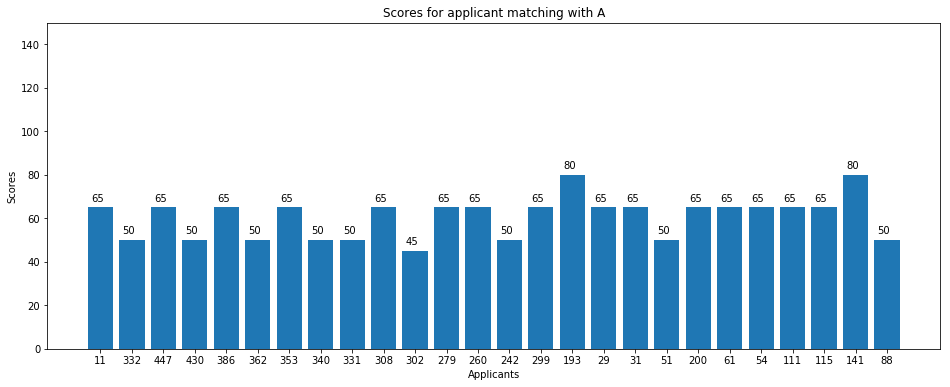

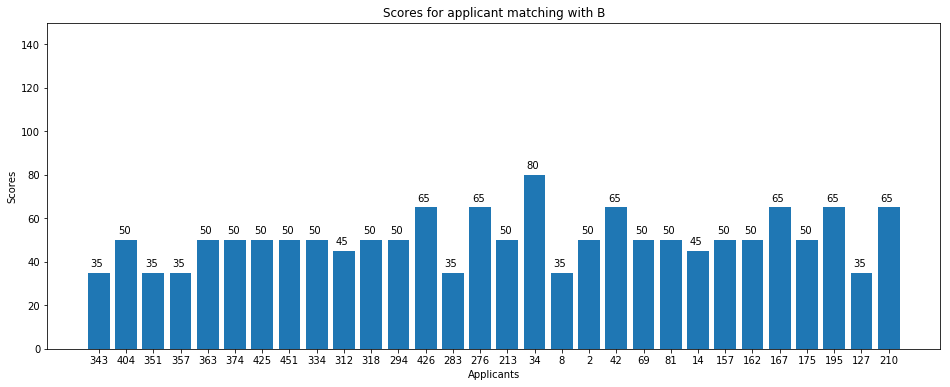

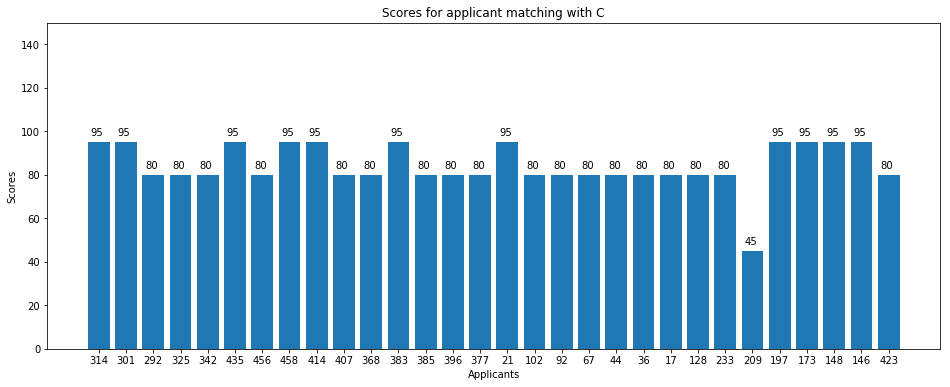

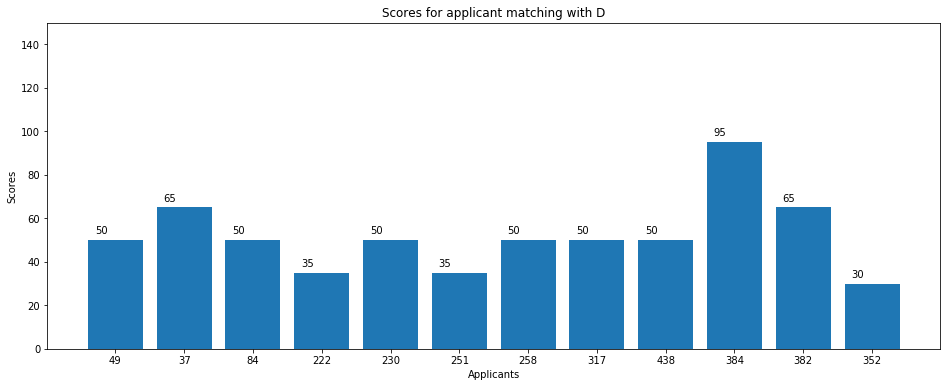

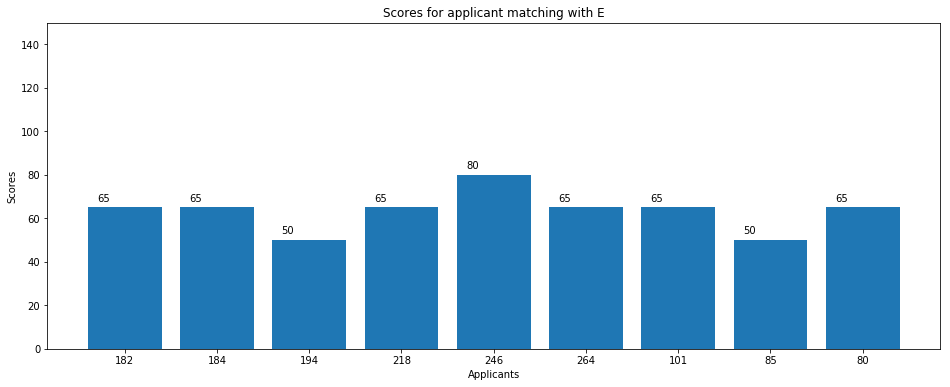

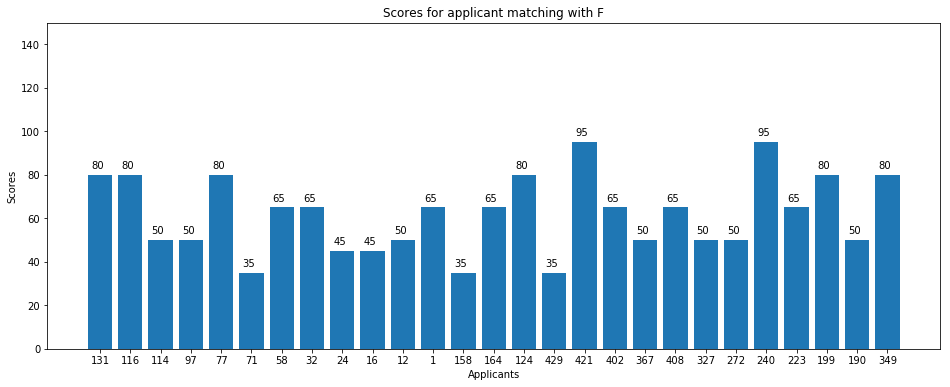

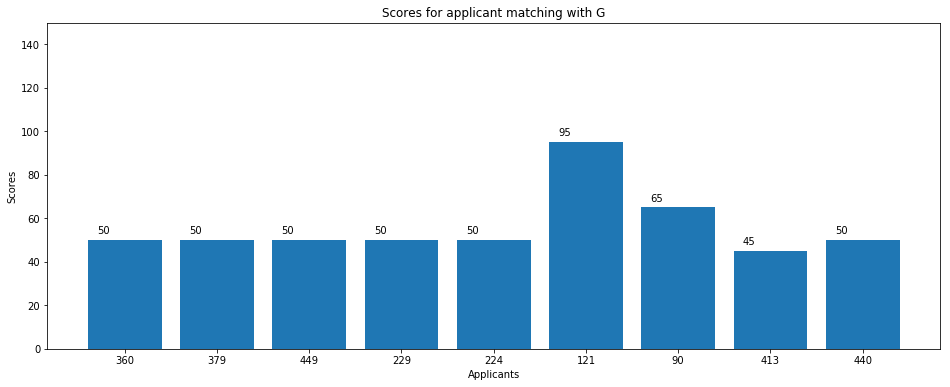

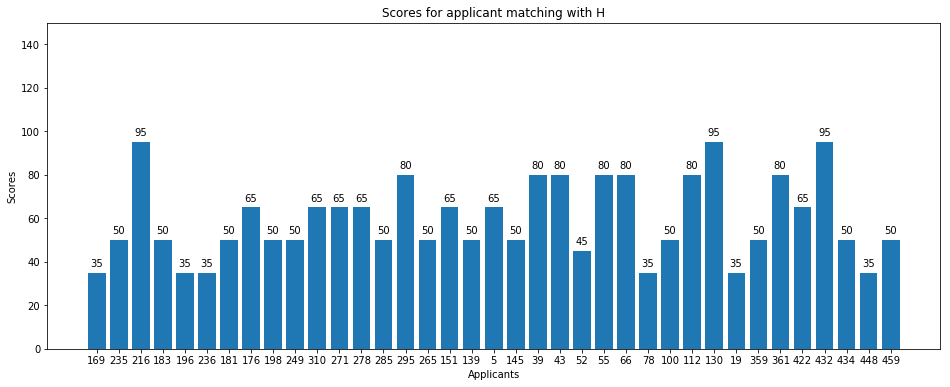

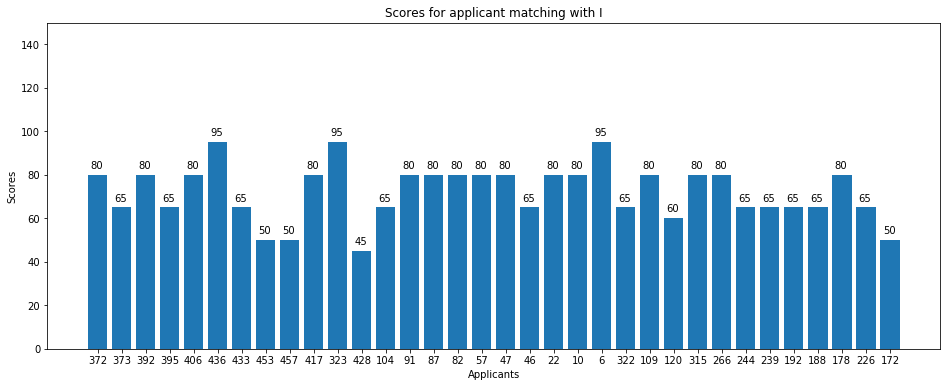

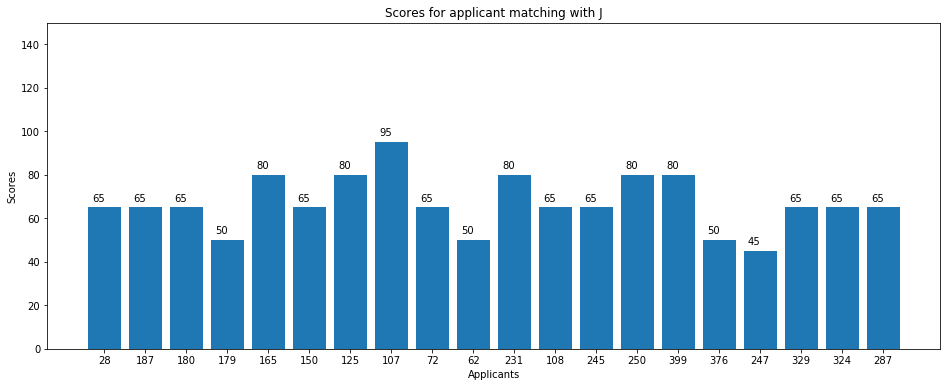

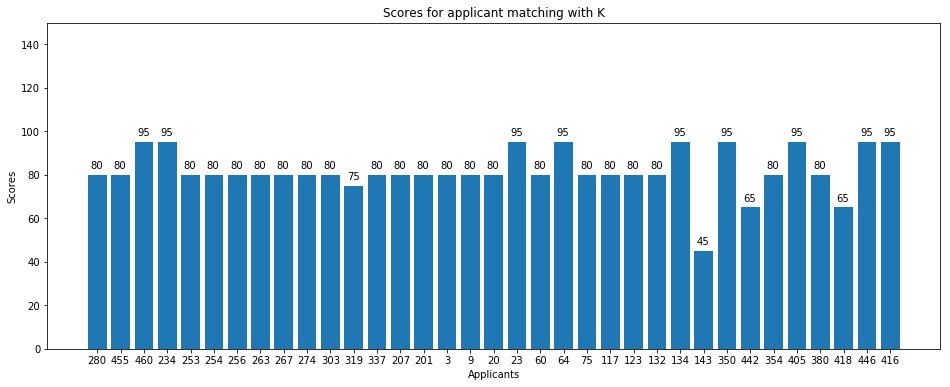

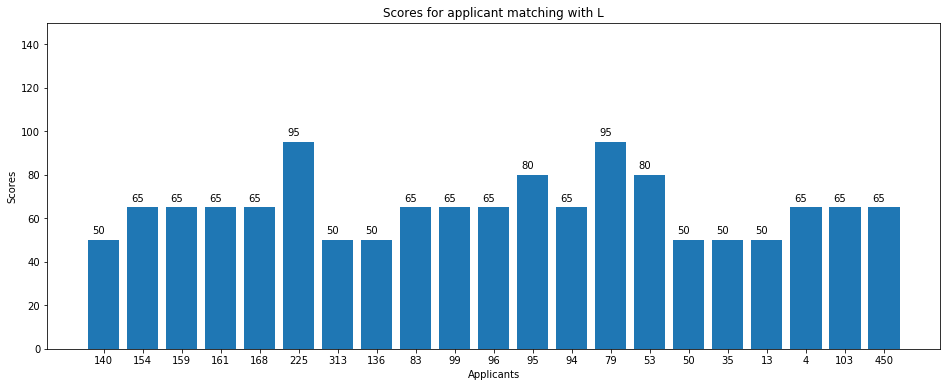

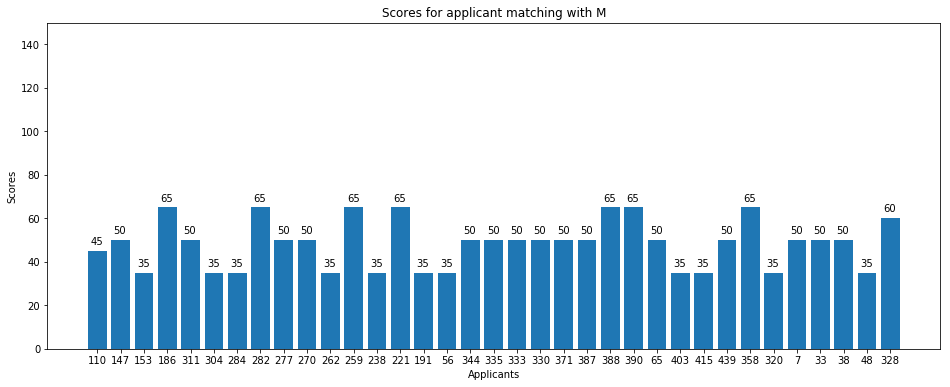

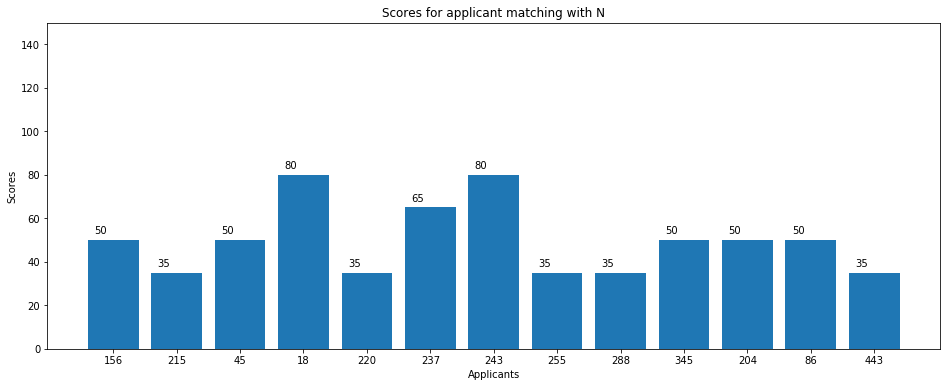

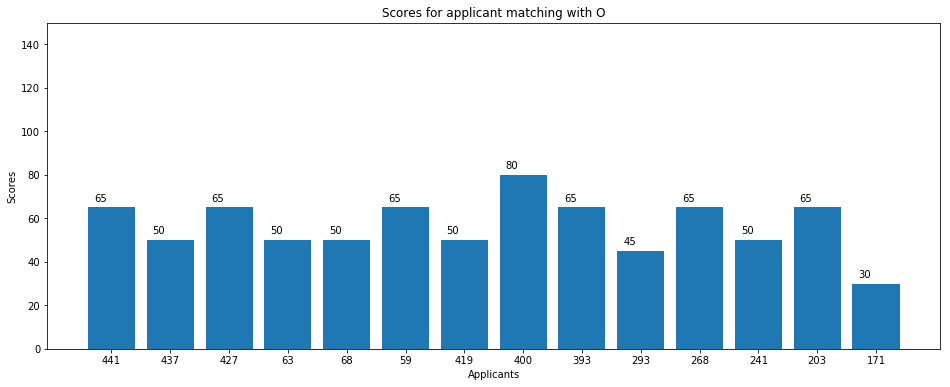

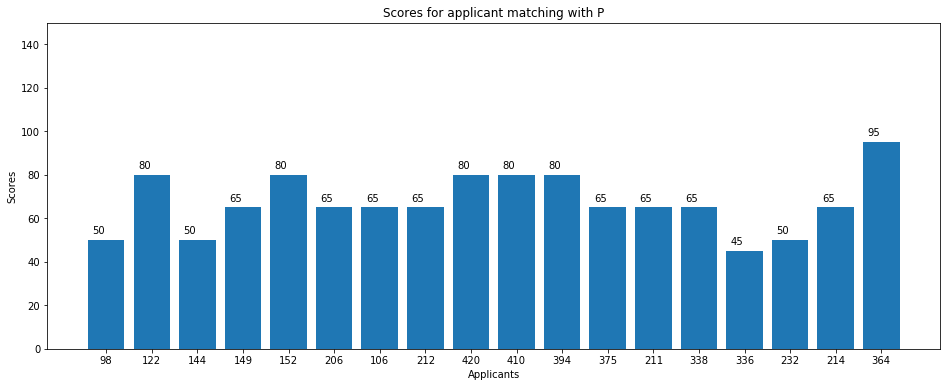

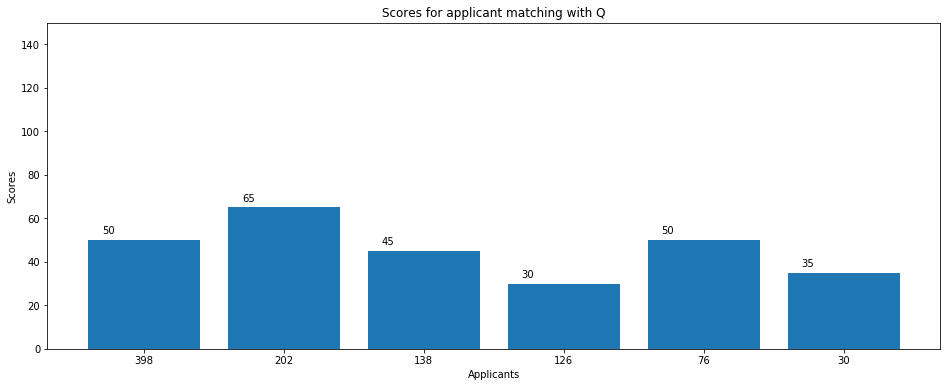

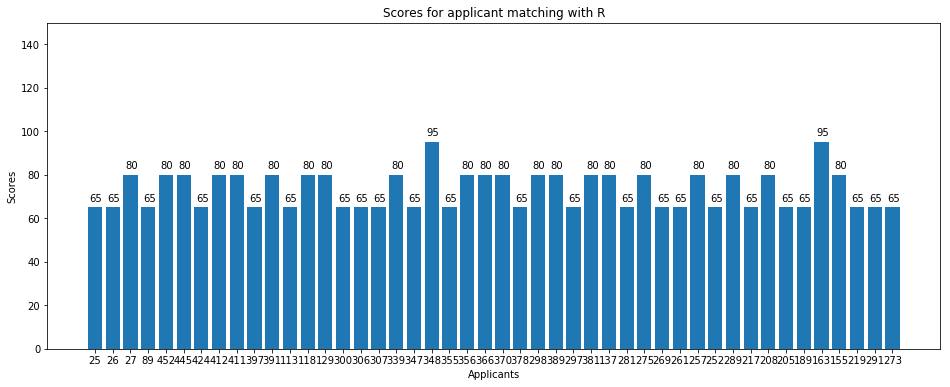

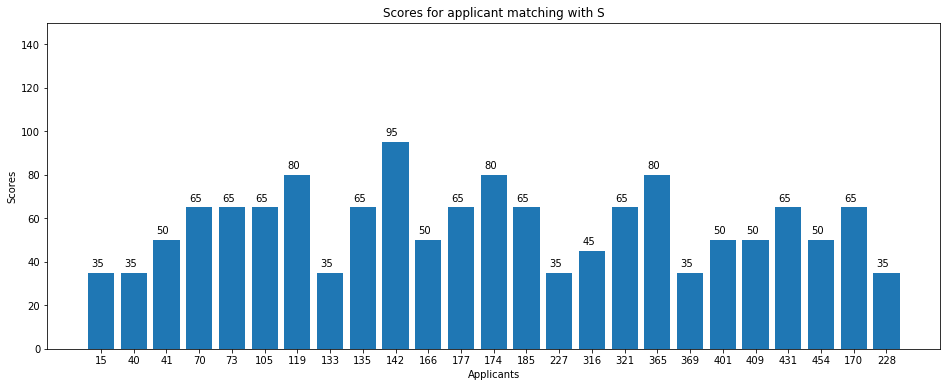

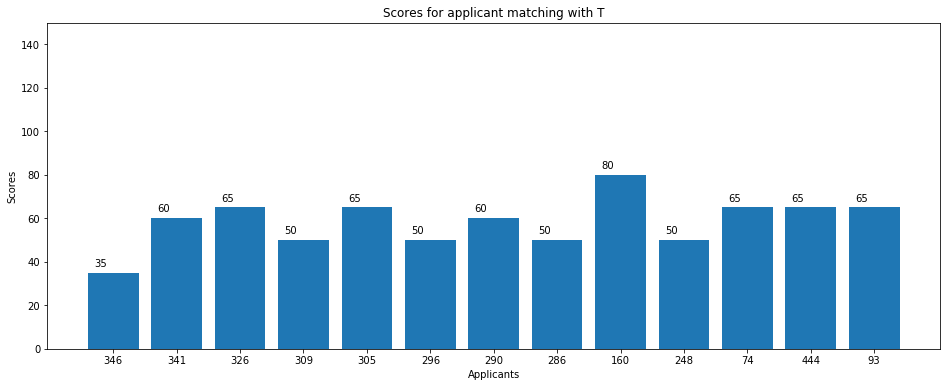

In [59]:
final_matches = top_matches_only.copy()

y = 0
while y < len(mentors):
    x = 0
    labels = []
    points = []
    while x < len(final_matches):
        if mentors['MENTOR'].iloc[y] == final_matches['MENTOR'].iloc[x]:
            labels.append(final_matches['APPLICANT'].iloc[x]) # create list of labels for bar chart
            points.append(str(final_matches['SCORE'].iloc[x])) # create list of corresponding values for bar chart
        x += 1
    
    fig = plt.figure(figsize=(16, 6)) # increase figure size
    ax = fig.add_subplot(111)
    ax.bar(np.arange(len(points)), points)
    ax.set_ylabel('Scores')
    ax.set_xlabel('Applicants')
    ax.set_title("Scores for applicant matching with {}".format(mentors['MENTOR'].iloc[y]))
    ax.set_xticks(np.arange(len(points)))
    ax.set_xticklabels(labels) 
    ax.set_ylim(0, 150)
    for i, v in enumerate(points):
        ax.text(i - .3, int(v) + 3, v)
    y += 1

## Matching admits in admission cycles

**NOTE**: Adds extra step of keeping previous matches, so that the distribution step takes into account the amount of previous matches a mentor has

* 5 matches a week through binding for 3 weeks
* 100 matches for Early Action
* 400 matches for Regular Decision
* 10 matches a week through Rolling Decision for 3 weeks

### Binding Decision 1

In [81]:
fa_admit_id =  admits["APPLICANT"][0:5].tolist()

In [82]:
fa_admit_country = []
x = 0
while x < len(admits[0:5]):
    split = unicode(admits["COUNTRY"][x]).split() # unicode necessary so that the object is the same of that of mentor_country
    fa_admit_country.append(split)
    x += 1

In [83]:
fa_admit_status = admits["2-STATUS"][0:5].tolist()

In [84]:
fa_admit_interests = []
x = 0
while x < len(admits[0:5]):
    split = str(admits["INTERESTS"][x]).split()
    split = set(split)
    split = list(split)
    fa_admit_interests.append(split)
    x += 1

In [85]:
applicant = []
student = []
scores = []
match(fa_admit_id, fa_admit_country, fa_admit_status, fa_admit_interests)

In [86]:
matches = pd.DataFrame(np.column_stack([student, applicant, scores]), 
                               columns=['MENTOR', 'APPLICANT', 'SCORE'])

In [87]:
applicant_labels = []
points = []
heatmap_data()

trace = go.Heatmap(z= points,
                   y= mentor_labels)
data=[trace]
layout = go.Layout(
    title='First Binding Decision: 5 Admits',
    xaxis=dict(
        title='Admits',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f')),
    yaxis = dict(
    title = 'Mentors',
    titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f')))

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='labelled-heatmap-binding-example')

In [88]:
# dataframe which only keeps the top matches per admit
by_applicant = matches.groupby("APPLICANT")["SCORE"].transform(max) == matches["SCORE"]
top_matches = matches[by_applicant]

# dataframe which sorts based on the mentor with the least to most matches
top_matches['count'] = top_matches.groupby(['MENTOR'])['APPLICANT'].transform('count') 
top_matches = top_matches.sort_values('count')

# drops duplicates, keeping only the first match (which is with mentor with the least matches)
top_matches_only = top_matches.drop_duplicates("APPLICANT", keep = "first")
del top_matches_only["count"] # deleting old count column

C:\Users\Kalia\Anaconda2\lib\site-packages\ipykernel\__main__.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [89]:
final_matches = top_matches_only.copy() # dataframe where next matches will be added

### Binding Decision 2

In [90]:
sa_admit_id =  admits["APPLICANT"][5:10].tolist()

sa_admit_country = []
x = 0
while x < len(admits[5:10]):
    split = unicode(admits["COUNTRY"][x]).split() # unicode necessary so that the object is the same of that of mentor_country
    sa_admit_country.append(split)
    x += 1
    
sa_admit_status = admits["2-STATUS"][5:10].tolist()

sa_admit_interests = []
x = 0
while x < len(admits[5:10]):
    split = str(admits["INTERESTS"][x]).split()
    split = set(split)
    split = list(split)
    sa_admit_interests.append(split)
    x += 1

In [91]:
applicant = []
student = []
scores = []
match(sa_admit_id, sa_admit_country, sa_admit_status, sa_admit_interests)

In [92]:
matches = pd.DataFrame(np.column_stack([student, applicant, scores]), 
                               columns=['MENTOR', 'APPLICANT', 'SCORE'])

In [93]:
applicant_labels = []
points = []
heatmap_data()

trace = go.Heatmap(z= points,
                   y= mentor_labels)
data=[trace]
layout = go.Layout(
    title='Second Binding Decision: 5 Admits',
    xaxis=dict(
        title='Admits',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f')),
    yaxis = dict(
    title = 'Mentors',
    titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f')))

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='labelled-heatmap-binding-2')

In [94]:
# dataframe which only keeps the top matches per admit
by_applicant = matches.groupby("APPLICANT")["SCORE"].transform(max) == matches["SCORE"]
top_matches = matches[by_applicant]

# merge matches before sorting for optimal match distribution
top_matches = pd.concat([final_matches, top_matches], axis = 0)

# dataframe which sorts based on the mentor with the least to most matches
top_matches['count'] = top_matches.groupby(['MENTOR'])['APPLICANT'].transform('count') 
top_matches = top_matches.sort_values('count')

# drops duplicates, keeping only the first match (which is with mentor with the least matches)
top_matches_only = top_matches.drop_duplicates("APPLICANT", keep = "first")
del top_matches_only["count"] # deleting old count column

In [95]:
final_matches = top_matches_only.copy() # dataframe where next matches will be added

### Binding Decision 3

In [96]:
ta_admit_id =  admits["APPLICANT"][10:15].tolist()

ta_admit_country = []
x = 0
while x < len(admits[10:15]):
    split = unicode(admits["COUNTRY"][x]).split() # unicode necessary so that the object is the same of that of mentor_country
    ta_admit_country.append(split)
    x += 1
    
ta_admit_status = admits["2-STATUS"][10:15].tolist()

ta_admit_interests = []
x = 0
while x < len(admits[10:15]):
    split = str(admits["INTERESTS"][x]).split()
    split = set(split)
    split = list(split)
    ta_admit_interests.append(split)
    x += 1

In [97]:
applicant = []
student = []
scores = []
match(ta_admit_id, ta_admit_country, ta_admit_status, ta_admit_interests)

In [98]:
matches = pd.DataFrame(np.column_stack([student, applicant, scores]), 
                               columns=['MENTOR', 'APPLICANT', 'SCORE'])

In [99]:
applicant_labels = []
points = []
heatmap_data()

trace = go.Heatmap(z= points,
                   y= mentor_labels)
data=[trace]
layout = go.Layout(
    title='Third Binding Decision: 5 Admits',
    xaxis=dict(
        title='Admits',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f')),
    yaxis = dict(
    title = 'Mentors',
    titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f')))

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='labelled-heatmap-binding-3')

In [100]:
# dataframe which only keeps the top matches per admit
by_applicant = matches.groupby("APPLICANT")["SCORE"].transform(max) == matches["SCORE"]
top_matches = matches[by_applicant]

# merge matches before sorting for optimal match distribution
top_matches = pd.concat([final_matches, top_matches], axis = 0)

# dataframe which sorts based on the mentor with the least to most matches
top_matches['count'] = top_matches.groupby(['MENTOR'])['APPLICANT'].transform('count') 
top_matches = top_matches.sort_values('count')

# drops duplicates, keeping only the first match (which is with mentor with the least matches)
top_matches_only = top_matches.drop_duplicates("APPLICANT", keep = "first")
del top_matches_only["count"] # deleting old count column

In [101]:
final_matches = top_matches_only.copy()

### Early Action

In [102]:
ea_admit_id =  admits["APPLICANT"][15:115].tolist()

ea_admit_country = []
x = 0
while x < len(admits[15:115]):
    split = unicode(admits["COUNTRY"][x]).split() # unicode necessary so that the object is the same of that of mentor_country
    ea_admit_country.append(split)
    x += 1
    
ea_admit_status = admits["2-STATUS"][15:115].tolist()

ea_admit_interests = []
x = 0
while x < len(admits[15:155]):
    split = str(admits["INTERESTS"][x]).split()
    split = set(split)
    split = list(split)
    ea_admit_interests.append(split)
    x += 1

In [103]:
applicant = []
student = []
scores = []
match(ea_admit_id, ea_admit_country, ea_admit_status, ea_admit_interests)

In [104]:
matches = pd.DataFrame(np.column_stack([student, applicant, scores]), 
                               columns=['MENTOR', 'APPLICANT', 'SCORE'])

In [105]:
applicant_labels = []
points = []
heatmap_data()

trace = go.Heatmap(z= points,
                   y= mentor_labels)
data=[trace]
layout = go.Layout(
    title='Early Action: 100 Admits',
    xaxis=dict(
        title='Admits',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f')),
    yaxis = dict(
    title = 'Mentors',
    titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f')))

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='labelled-heatmap-early-action')

In [106]:
# dataframe which only keeps the top matches per admit
by_applicant = matches.groupby("APPLICANT")["SCORE"].transform(max) == matches["SCORE"]
top_matches = matches[by_applicant]

# merge matches before sorting for optimal match distribution

top_matches = pd.concat([final_matches, top_matches], axis = 0)

# dataframe which sorts based on the mentor with the least to most matches
top_matches['count'] = top_matches.groupby(['MENTOR'])['APPLICANT'].transform('count') 
top_matches = top_matches.sort_values('count')

# drops duplicates, keeping only the first match (which is with mentor with the least matches)
top_matches_only = top_matches.drop_duplicates("APPLICANT", keep = "first")
del top_matches_only["count"] # deleting old count column

In [107]:
final_matches = top_matches_only.copy()

### Regular Decision

In [108]:
rd_admit_id =  admits["APPLICANT"][115:415].tolist()

rd_admit_country = []
x = 0
while x < len(admits[115:415]):
    split = unicode(admits["COUNTRY"][x]).split() # unicode necessary so that the object is the same of that of mentor_country
    rd_admit_country.append(split)
    x += 1
    
rd_admit_status = admits["2-STATUS"][115:415].tolist()

rd_admit_interests = []
x = 0
while x < len(admits[15:415]):
    split = str(admits["INTERESTS"][x]).split()
    split = set(split)
    split = list(split)
    rd_admit_interests.append(split)
    x += 1

In [109]:
applicant = []
student = []
scores = []
match(rd_admit_id, rd_admit_country, rd_admit_status, rd_admit_interests)

In [110]:
matches = pd.DataFrame(np.column_stack([student, applicant, scores]), 
                               columns=['MENTOR', 'APPLICANT', 'SCORE'])

In [111]:
applicant_labels = []
points = []
heatmap_data()

trace = go.Heatmap(z= points,
                   y= mentor_labels)
data=[trace]
layout = go.Layout(
    title='Regular Decision: 400 Admits',
    xaxis=dict(
        title='Admits',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f')),
    yaxis = dict(
    title = 'Mentors',
    titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f')))

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='labelled-heatmap-regular-decision')

In [112]:
# dataframe which only keeps the top matches per admit
by_applicant = matches.groupby("APPLICANT")["SCORE"].transform(max) == matches["SCORE"]
top_matches = matches[by_applicant]

# merge matches before sorting for optimal match distribution
top_matches = pd.concat([final_matches, top_matches], axis = 0)

# dataframe which sorts based on the mentor with the least to most matches
top_matches['count'] = top_matches.groupby(['MENTOR'])['APPLICANT'].transform('count') 
top_matches = top_matches.sort_values('count')

# drops duplicates, keeping only the first match (which is with mentor with the least matches)
top_matches_only = top_matches.drop_duplicates("APPLICANT", keep = "first")
del top_matches_only["count"] # deleting old count column

In [114]:
final_matches = top_matches_only.copy()

### Rolling Decision 1

In [115]:
rd1_admit_id =  admits["APPLICANT"][415:430].tolist()

rd1_admit_country = []
x = 0
while x < len(admits[415:430]):
    split = unicode(admits["COUNTRY"][x]).split() # unicode necessary so that the object is the same of that of mentor_country
    rd1_admit_country.append(split)
    x += 1
    
rd1_admit_status = admits["2-STATUS"][415:430].tolist()

rd1_admit_interests = []
x = 0
while x < len(admits[415:430]):
    split = str(admits["INTERESTS"][x]).split()
    split = set(split)
    split = list(split)
    rd1_admit_interests.append(split)
    x += 1

In [116]:
applicant = []
student = []
scores = []
match(rd1_admit_id, rd1_admit_country, rd1_admit_status, rd1_admit_interests)

In [117]:
matches = pd.DataFrame(np.column_stack([student, applicant, scores]), 
                               columns=['MENTOR', 'APPLICANT', 'SCORE'])

In [118]:
applicant_labels = []
points = []
heatmap_data()

trace = go.Heatmap(z= points,
                   y= mentor_labels)
data=[trace]
layout = go.Layout(
    title='Rolling Decision 1: 15 Admits',
    xaxis=dict(
        title='Admits',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f')),
    yaxis = dict(
    title = 'Mentors',
    titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f')))

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='labelled-heatmap-rolling-decision-1')

In [120]:
# dataframe which only keeps the top matches per admit
by_applicant = matches.groupby("APPLICANT")["SCORE"].transform(max) == matches["SCORE"]
top_matches = matches[by_applicant]

# merge matches before sorting for optimal match distribution
top_matches = pd.concat([final_matches, top_matches], axis = 0)

# dataframe which sorts based on the mentor with the least to most matches
top_matches['count'] = top_matches.groupby(['MENTOR'])['APPLICANT'].transform('count') 
top_matches = top_matches.sort_values('count')

# drops duplicates, keeping only the first match (which is with mentor with the least matches)
top_matches_only = top_matches.drop_duplicates("APPLICANT", keep = "first")
del top_matches_only["count"] # deleting old count column

In [121]:
final_matches = top_matches_only.copy()

### Rolling Decision 2

In [122]:
rd2_admit_id =  admits["APPLICANT"][430:445].tolist()

rd2_admit_country = []
x = 0
while x < len(admits[430:445]):
    split = unicode(admits["COUNTRY"][x]).split() # unicode necessary so that the object is the same of that of mentor_country
    rd2_admit_country.append(split)
    x += 1
    
rd2_admit_status = admits["2-STATUS"][430:445].tolist()

rd2_admit_interests = []
x = 0
while x < len(admits[430:445]):
    split = str(admits["INTERESTS"][x]).split()
    split = set(split)
    split = list(split)
    rd2_admit_interests.append(split)
    x += 1

In [123]:
applicant = []
student = []
scores = []
match(rd2_admit_id, rd2_admit_country, rd2_admit_status, rd2_admit_interests)

In [124]:
matches = pd.DataFrame(np.column_stack([student, applicant, scores]), 
                               columns=['MENTOR', 'APPLICANT', 'SCORE'])

In [125]:
applicant_labels = []
points = []
heatmap_data()

trace = go.Heatmap(z= points,
                   y= mentor_labels)
data=[trace]
layout = go.Layout(
    title='Rolling Decision 2: 15 Admits',
    xaxis=dict(
        title='Admits',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f')),
    yaxis = dict(
    title = 'Mentors',
    titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f')))

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='labelled-heatmap-rolling-decision-2')

In [126]:
# dataframe which only keeps the top matches per admit
by_applicant = matches.groupby("APPLICANT")["SCORE"].transform(max) == matches["SCORE"]
top_matches = matches[by_applicant]

# merge matches before sorting for optimal match distribution
top_matches = pd.concat([final_matches, top_matches], axis = 0)

# dataframe which sorts based on the mentor with the least to most matches
top_matches['count'] = top_matches.groupby(['MENTOR'])['APPLICANT'].transform('count') 
top_matches = top_matches.sort_values('count')

# drops duplicates, keeping only the first match (which is with mentor with the least matches)
top_matches_only = top_matches.drop_duplicates("APPLICANT", keep = "first")
del top_matches_only["count"] # deleting old count column

In [127]:
final_matches = top_matches_only.copy()

### Rolling Decision 3

In [128]:
rd3_admit_id =  admits["APPLICANT"][445:460].tolist()

rd3_admit_country = []
x = 0
while x < len(admits[445:460]):
    split = unicode(admits["COUNTRY"][x]).split() # unicode necessary so that the object is the same of that of mentor_country
    rd3_admit_country.append(split)
    x += 1
    
rd3_admit_status = admits["2-STATUS"][445:460].tolist()

rd3_admit_interests = []
x = 0
while x < len(admits[445:460]):
    split = str(admits["INTERESTS"][x]).split()
    split = set(split)
    split = list(split)
    rd3_admit_interests.append(split)
    x += 1

In [129]:
applicant = []
student = []
scores = []
match(rd3_admit_id, rd3_admit_country, rd3_admit_status, rd3_admit_interests)

In [130]:
matches = pd.DataFrame(np.column_stack([student, applicant, scores]), 
                               columns=['MENTOR', 'APPLICANT', 'SCORE'])

In [131]:
applicant_labels = []
points = []
heatmap_data()

trace = go.Heatmap(z= points,
                   y= mentor_labels)
data=[trace]
layout = go.Layout(
    title='Rolling Decision 3: 15 Admits',
    xaxis=dict(
        title='Admits',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f')),
    yaxis = dict(
    title = 'Mentors',
    titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f')))

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='labelled-heatmap-rolling-decision-3')

In [132]:
# dataframe which only keeps the top matches per admit
by_applicant = matches.groupby("APPLICANT")["SCORE"].transform(max) == matches["SCORE"]
top_matches = matches[by_applicant]

# merge matches before sorting for optimal match distribution
top_matches = pd.concat([final_matches, top_matches], axis = 0)

# dataframe which sorts based on the mentor with the least to most matches
top_matches['count'] = top_matches.groupby(['MENTOR'])['APPLICANT'].transform('count') 
top_matches = top_matches.sort_values('count')

# drops duplicates, keeping only the first match (which is with mentor with the least matches)
top_matches_only = top_matches.drop_duplicates("APPLICANT", keep = "first")
del top_matches_only["count"] # deleting old count column

In [134]:
final_matches = top_matches_only.copy()

### Bar Charts of Matches per Mentor

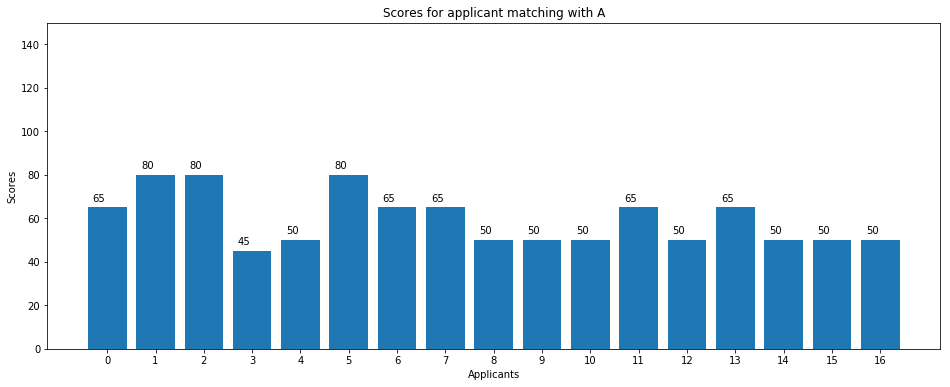

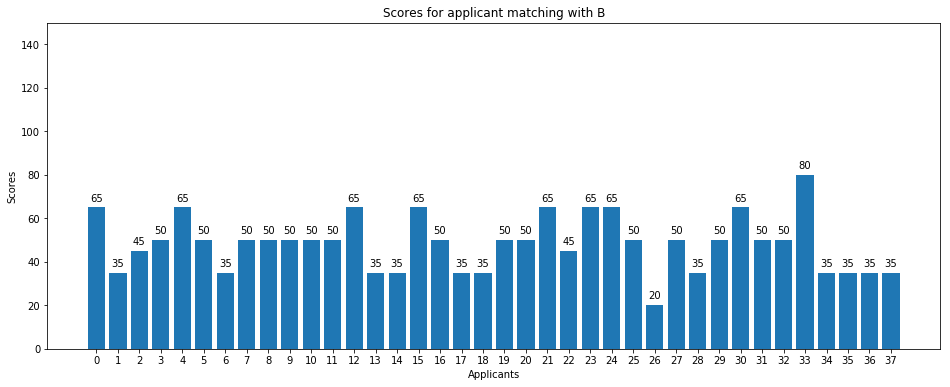

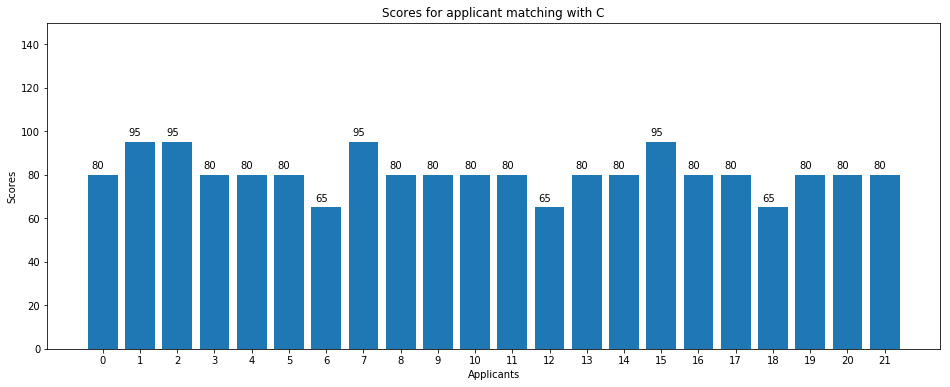

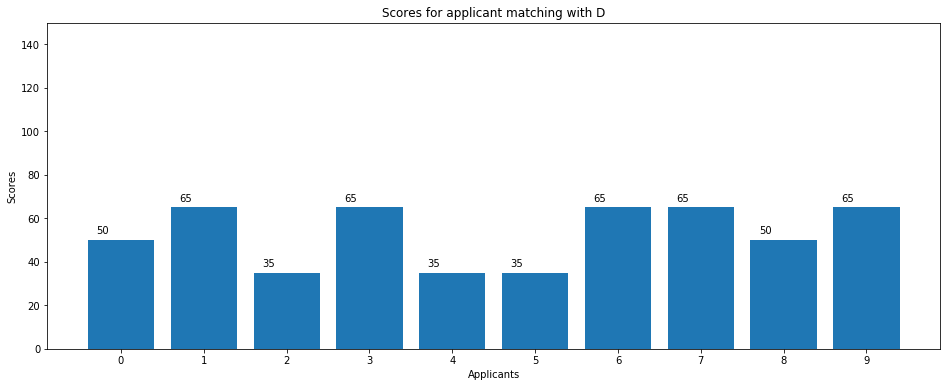

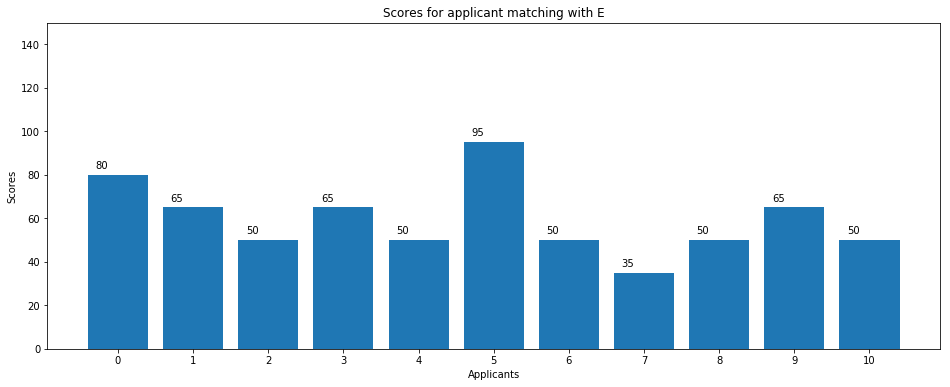

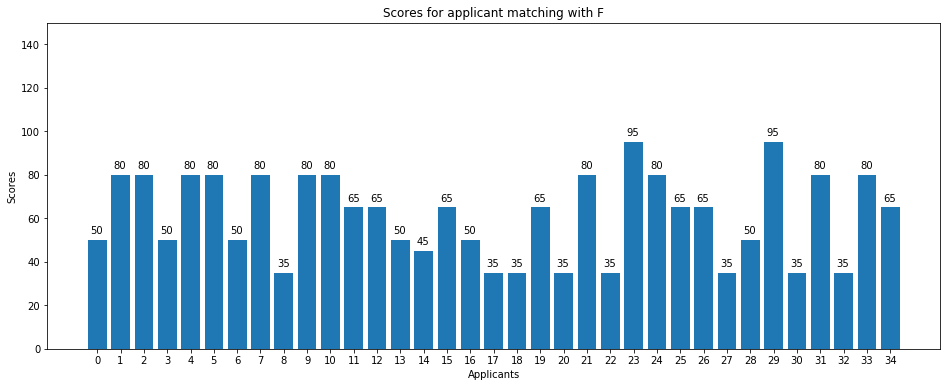

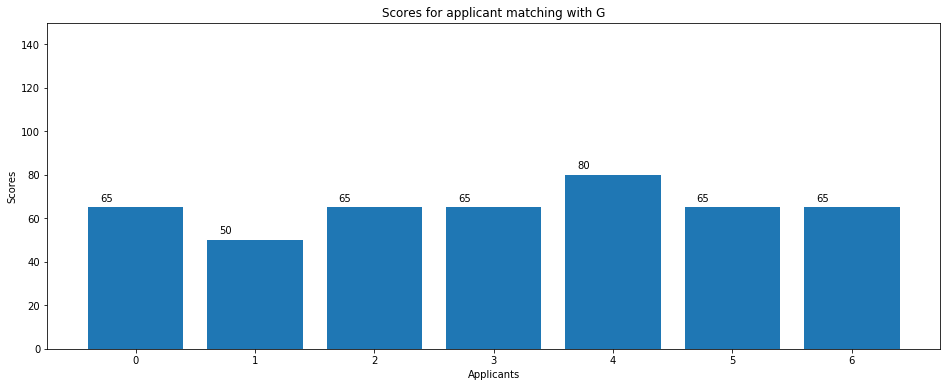

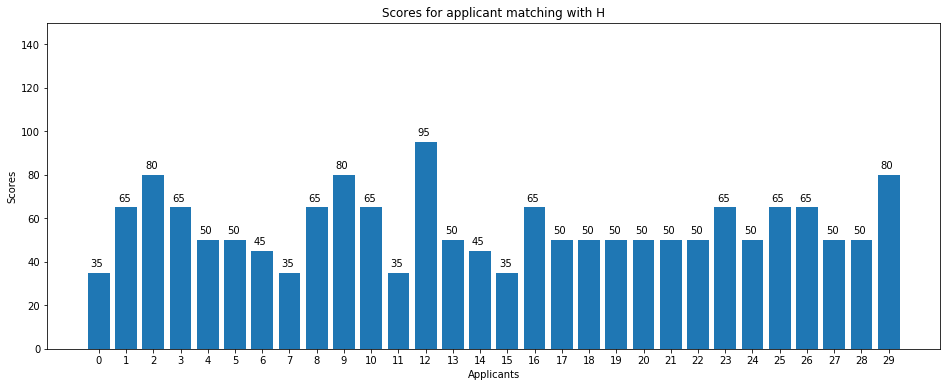

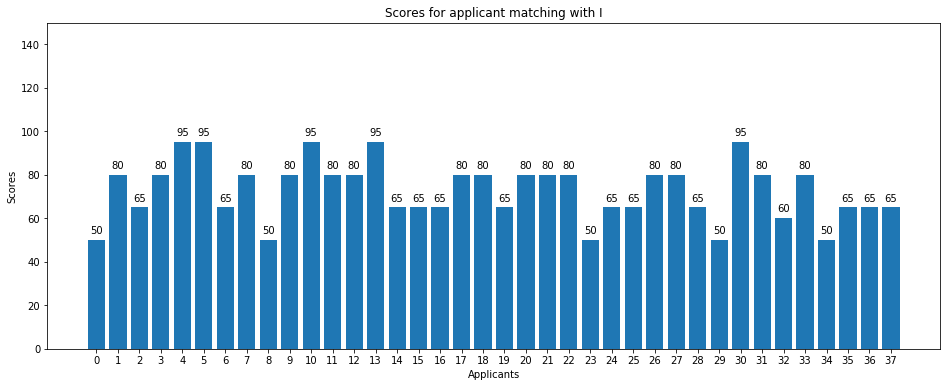

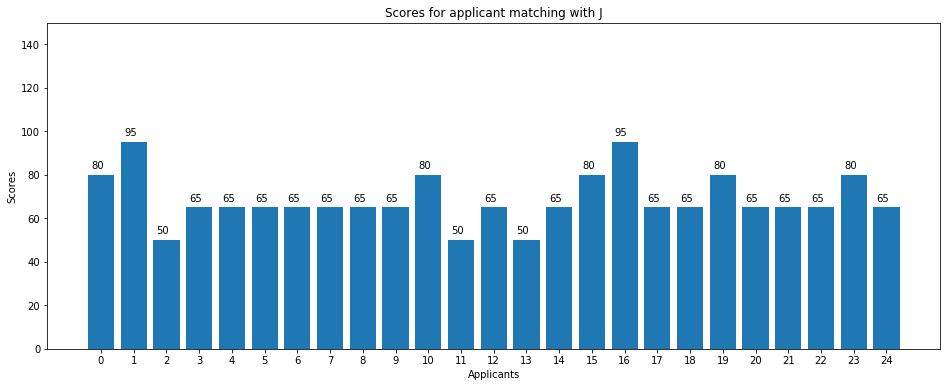

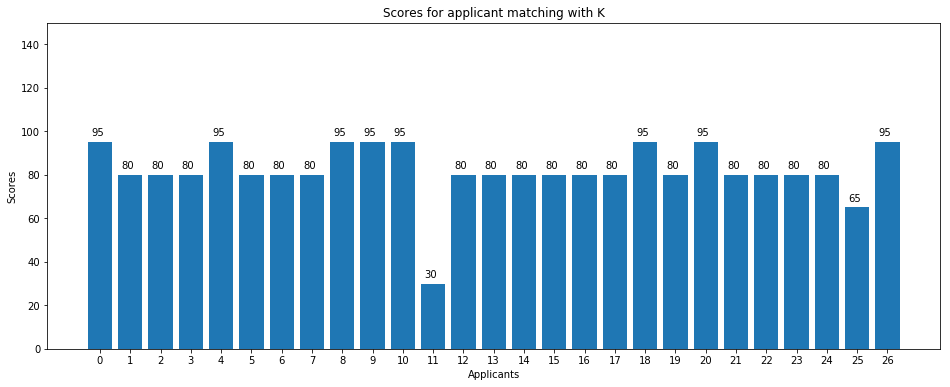

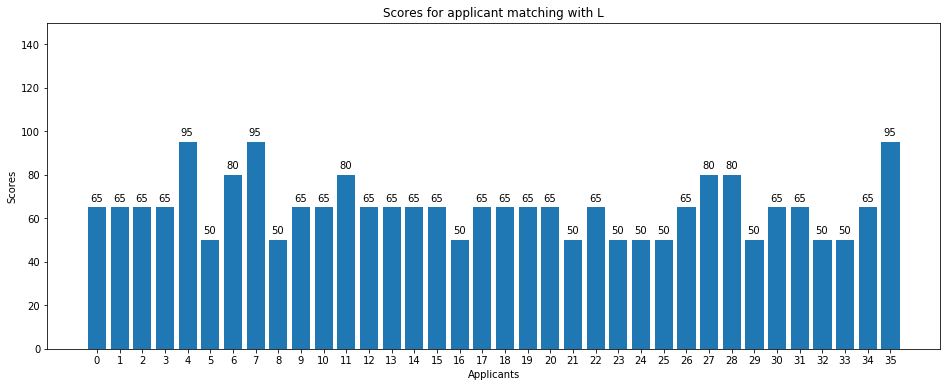

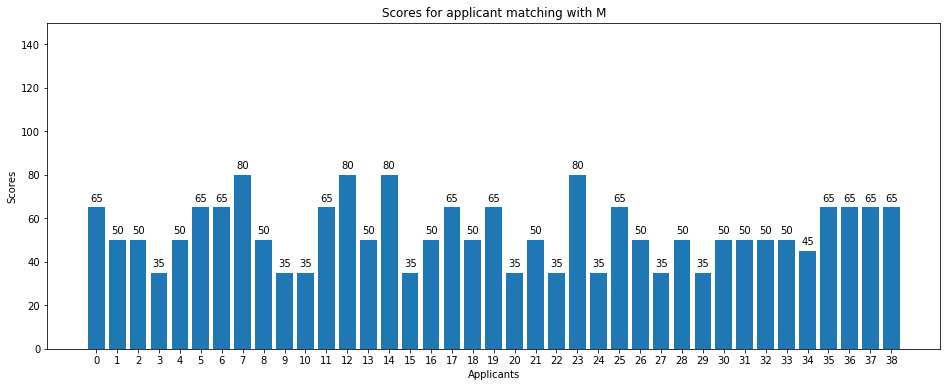

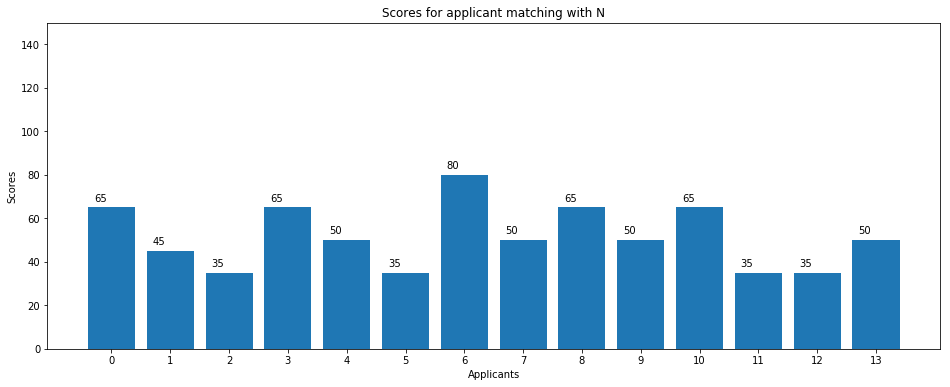

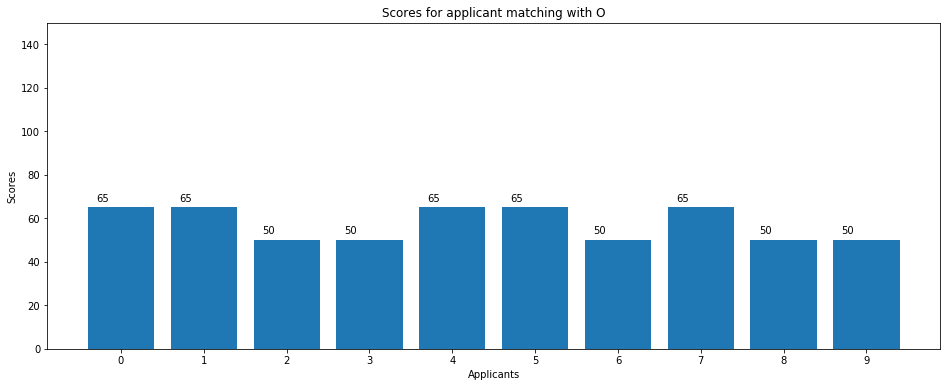

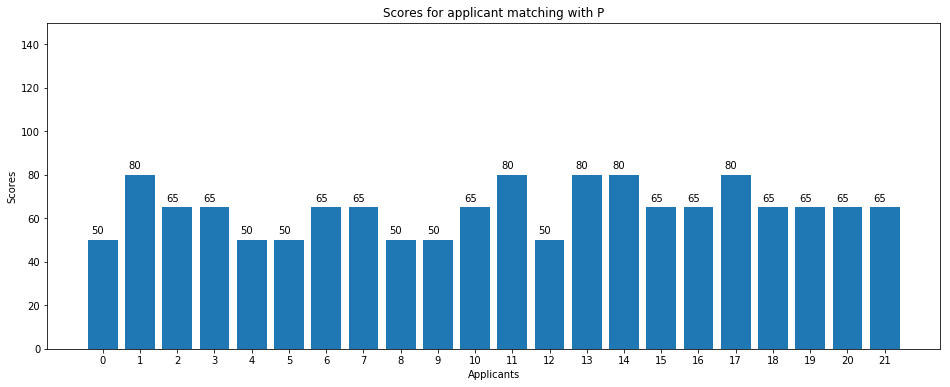

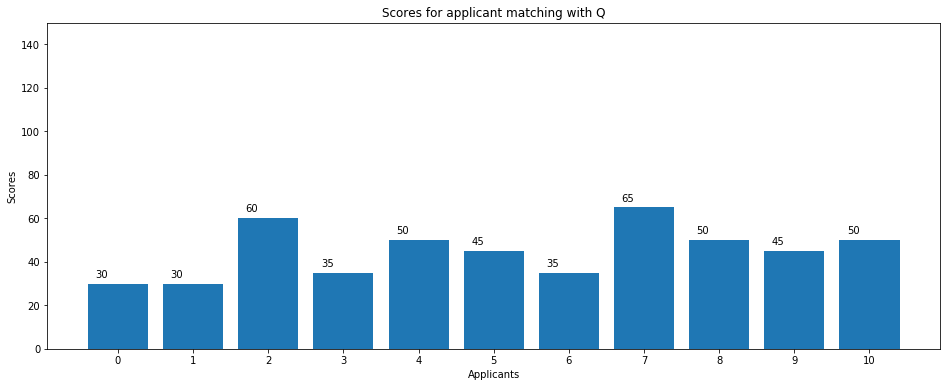

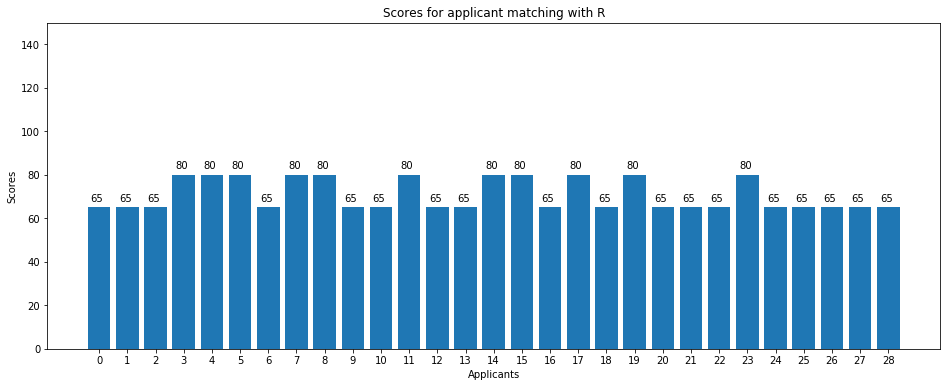

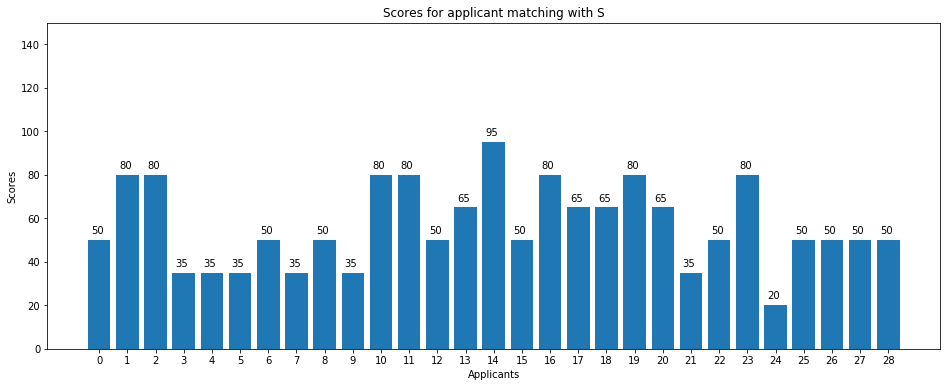

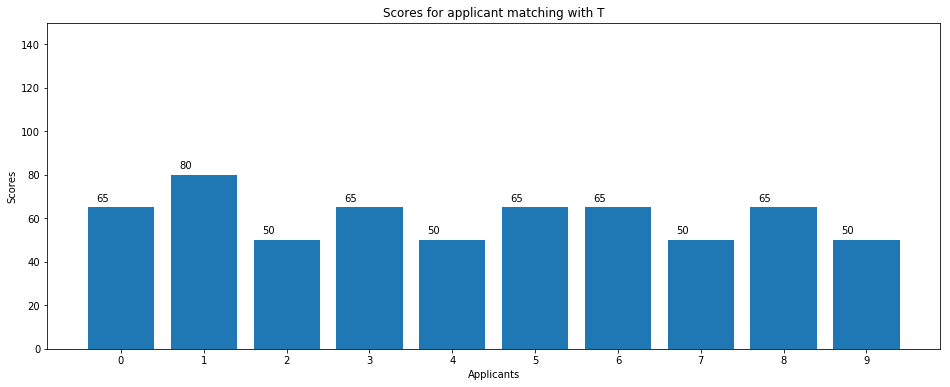

In [135]:
y = 0
while y < len(mentors):
    x = 0
    labels = []
    points = []
    while x < len(final_matches):
        if mentors['MENTOR'].iloc[y] == final_matches['MENTOR'].iloc[x]:
            labels.append(final_matches['APPLICANT'].iloc[x]) # create list of labels for bar chart
            points.append(str(final_matches['SCORE'].iloc[x])) # create list of corresponding values for bar chart
        x += 1
    
    fig = plt.figure(figsize=(16, 6)) # increase figure size
    ax = fig.add_subplot(111)
    ax.bar(np.arange(len(points)), points)
    ax.set_ylabel('Scores')
    ax.set_xlabel('Applicants')
    ax.set_title("Scores for applicant matching with {}".format(mentors['MENTOR'].iloc[y]))
    ax.set_xticks(np.arange(len(points)))
    #ax.set_xticklabels(labels, rotation = 90)
    ax.set_ylim(0, 150)
    for i, v in enumerate(points):
        ax.text(i - .3, int(v) + 3, v)
    y += 1

In [136]:
writer = pd.ExcelWriter('cycled_mentor_applicant_matches.xlsx')
final_matches.to_excel(writer,'Sheet1')
writer.save()